# Overview 
- [ ] PDF
- [ ] time series
- [ ] spectra
- [ ] x/y trajectories

In [6]:
import xarray as xr
import pandas as pd
import numpy as np

import os

import hvplot.xarray
import hvplot.pandas

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

import pynsitu as pyn
import lib as lib
from lib import raw_dir, root_dir, images_dir, KEYS, color

import synthetic_traj as st

from synthetic_traj import synthetic_traj, N , T, tau_eta, n_layers, U_low, U_ni, U_2, U_1

In [7]:
## PARAMETERS

# timeline: 50 days with 1 min sampling
nb_jour = 100
sampling_min = 1

dt = 1/24/60*sampling_min
t = (nb_jour, dt)
# number of random draws
N = 10

# use a common decorrelation timescale, no rationale
#T = [5,10,20,40]
T = 10

# velocity amplitudes
U_low = 0.3
U_ni = 0.2#0.2
U_2 = 0.05
U_1 = 0.02
tau_eta = 0.1 # short timescale
n_layers = 5 # number of layers

param_str = f'Period = {period} days, dt = {sampling_min}min, draws = {N},\n T={T} days, ' +r'$\tau_{\eta}$ =' + str(tau_eta) +' days\n'+ r'$\sigma_{low}$=' + str(U_low) + r'm/s, $\sigma_{ni}$=' + str(U_ni)+ fr'm/s, $\sigma_2$={U_2}m/s, $\sigma_1$={U_1}m/s'

In [9]:
# True value with small dt
ds_true = synthetic_traj(t, N , T, tau_eta, n_layers, U_low=U_low, U_ni=U_ni, U_2=U_2, U_1=U_1, all_component_pos_acc=True)
st.add_norm(ds_true)
st.add_norm(ds_true, prefix = '_low')
st.add_norm(ds_true, prefix = '_ni')
st.add_norm(ds_true, prefix = '_1')
st.add_norm(ds_true, prefix = '_2')


In [10]:
suffix = ['', '_low', '_ni', '_1', '_2']
Ex_list = []
Eu_list = []
Ea_list = []
for suf in suffix :
    Ex_list.append(sigp.spectrum_welch(ds_true['x' + suf]+1j*ds_true['y' + suf], T=100 )[0].rename('Ex'+suf))
    Eu_list.append(sigp.spectrum_welch(ds_true['u' + suf]+1j*ds_true['v' + suf], T=100 )[0].rename('Eu'+suf))
    Ea_list.append(sigp.spectrum_welch(ds_true['ax' + suf]+1j*ds_true['ay' + suf], T=100 )[0].rename('Ea'+suf))
Enegpos = xr.merge(Ex_list + Eu_list + Ea_list )
                  
def negpos_spectra(ds, freqkey="freq_time"):
    """Return two datasets with cyclonic/anticyclonic spectra"""
    ds_inv = ds.sortby(freqkey, ascending=False)
    dsneg = ds_inv.where(ds_inv[freqkey] <= 0, drop=True)
    dsneg[freqkey] = -dsneg[freqkey]
    dspos = ds.where(ds[freqkey] >= 0, drop=True)
    return dsneg, dspos
                  
Eneg, Epos = negpos_spectra(Enegpos)
E = (Eneg+Epos).mean('draw')

0.0006944444444328704
0.0006944444444328704
0.0006944444444328704
0.0006944444444328704
0.0006944444444328704
0.0006944444444328704
0.0006944444444328704
0.0006944444444328704
0.0006944444444328704
0.0006944444444328704
0.0006944444444328704
0.0006944444444328704
0.0006944444444328704
0.0006944444444328704
0.0006944444444328704


In [126]:
E

<xarray.Dataset>
Dimensions:    (freq_time: 72000)
Coordinates:
  * freq_time  (freq_time) float64 -0.0 0.01 0.02 0.03 ... 720.0 720.0 720.0
Data variables: (12/15)
    Ex         (freq_time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    Ex_low     (freq_time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    Ex_ni      (freq_time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    Ex_1       (freq_time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    Ex_2       (freq_time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    Eu         (freq_time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    ...         ...
    Eu_2       (freq_time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    Ea         (freq_time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    Ea_low     (freq_time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    Ea_ni      (freq_time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    Ea_1       (freq_time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    Ea_2       (freq_time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>

______________
# Velocities


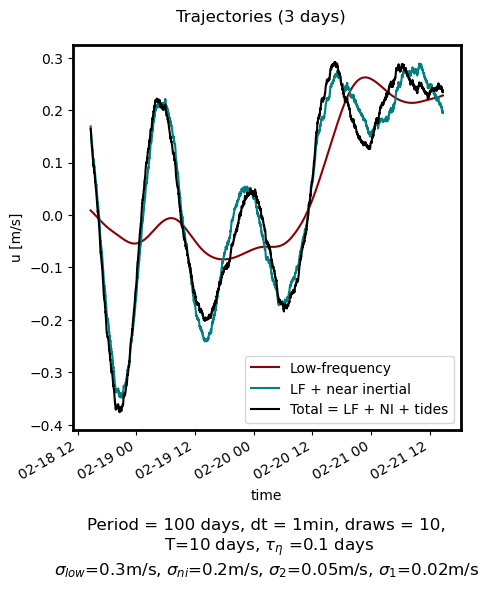

In [148]:
draw=4
nb_jours = 3
start = 70000
_ds = ds_true.isel(draw=draw).isel(time =slice(start, start + 24*60*nb_jours))
fig, ax= plt.subplots(1,1, figsize = (5,5))
_ds.u_low.plot( color = 'darkred', label = 'Low-frequency')
(_ds.u_ni+_ds.u_low).plot(color = 'teal', label = 'LF + near inertial')
_ds.u.plot( color = 'k', label = 'Total = LF + NI + tides')
ax.legend()
ax.set_title(param_str, y=-0.4)
ax.set_ylabel('u [m/s]')
fig.suptitle(f'Trajectories ({nb_jours} days)', y=0.95 )
fig.savefig(os.path.join(images_dir, 'synth_traj_zoom_traj_comp.png'), dpi = 200)

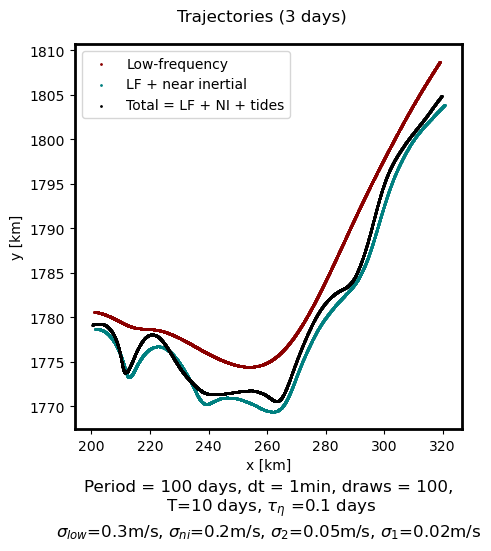

In [117]:
draw=4
nb_jours = 3
start = 70000
_ds = ds_true.isel(draw=draw).isel(time =slice(start, start + 24*60*nb_jours))
fig, ax= plt.subplots(1,1, figsize = (5,5))
ax.scatter(_ds.x_low/1000, _ds.y_low/1000, s=1, color = 'darkred', label = 'Low-frequency')
ax.scatter(_ds.x_low/1000 + _ds.x_ni/1000, _ds.y_low/1000 +_ds.y_ni/1000, s=1, color = 'teal', label = 'LF + near inertial')
ax.scatter(_ds.x/1000, _ds.y/1000, s=1, color = 'k', label = 'Total = LF + NI + tides')
ax.legend()
ax.set_title(param_str, y=-0.3)
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
fig.suptitle(f'Trajectories ({nb_jours} days)', y=0.95 )
fig.savefig(os.path.join(images_dir, 'synth_traj_zoom_traj_comp.png'), dpi = 200)

______________
# Correlation

In [127]:
cor_u = sigp.correlate(ds_true.u, ds_true.u).mean('draw')
print(0)
cor_u_low = sigp.correlate(ds_true.u_low, ds_true.u_low).mean('draw')
print(0)
cor_u_ni = sigp.correlate(ds_true.u_ni, ds_true.u_ni).mean('draw')
print(0)
cor_1 = sigp.correlate(ds_true.u_1, ds_true.u_1).mean('draw')
print(0)
cor_2 = sigp.correlate(ds_true.u_2, ds_true.u_2).mean('draw')

0
0
0
0


In [139]:
cor_2['lags'] = cor_2['lags']/(24*3600*1e9)

Text(0.5, 1.0, 'Semi-diurnal tide')

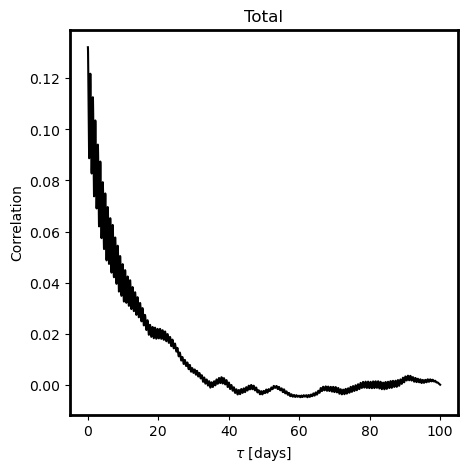

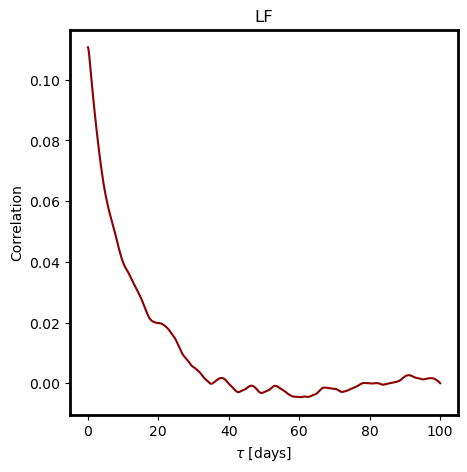

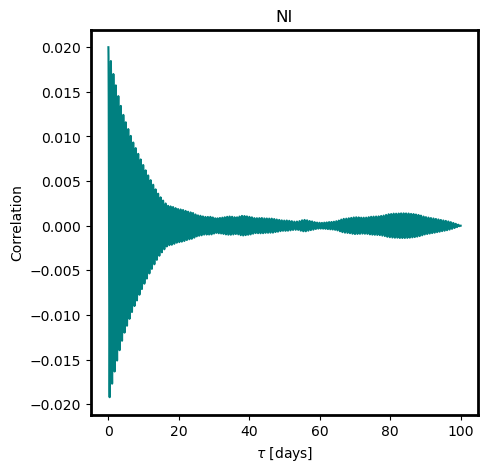

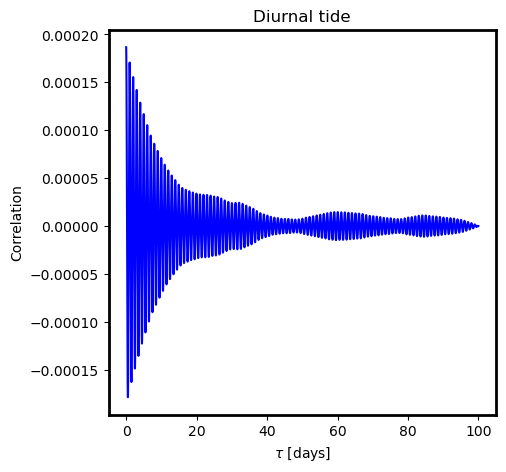

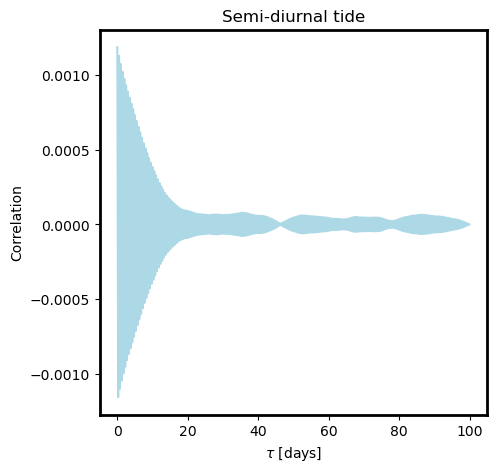

In [141]:
fig, ax= plt.subplots(1,1, figsize = (5,5))
cor_u.plot(color = 'k', ax=ax)
ax.set_xlabel(r'$\tau$ [days]')
ax.set_ylabel('Correlation')
ax.set_title('Total')

fig, ax= plt.subplots(1,1, figsize = (5,5))
cor_u_low.plot(color = 'darkred', ax=ax)
ax.set_xlabel(r'$\tau$ [days]')
ax.set_ylabel('Correlation')
ax.set_title('LF')

fig, ax= plt.subplots(1,1, figsize = (5,5))
cor_u_ni.plot(color = 'teal', ax=ax)
ax.set_xlabel(r'$\tau$ [days]')
ax.set_ylabel('Correlation')
ax.set_title('NI')

fig, ax= plt.subplots(1,1, figsize = (5,5))
cor_1.plot(color = 'blue', ax=ax)
ax.set_xlabel(r'$\tau$ [days]')
ax.set_ylabel('Correlation')
ax.set_title('Diurnal tide')

fig, ax= plt.subplots(1,1, figsize = (5,5))
cor_2.plot(color = 'lightblue', ax=ax)
ax.set_xlabel(r'$\tau$ [days]')
ax.set_ylabel('Correlation')
ax.set_title('Semi-diurnal tide')

______________
# PDF

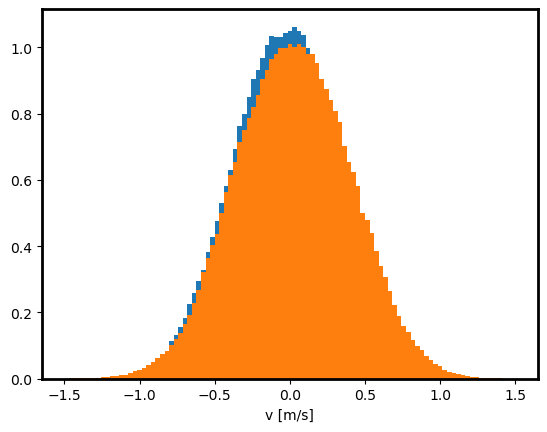

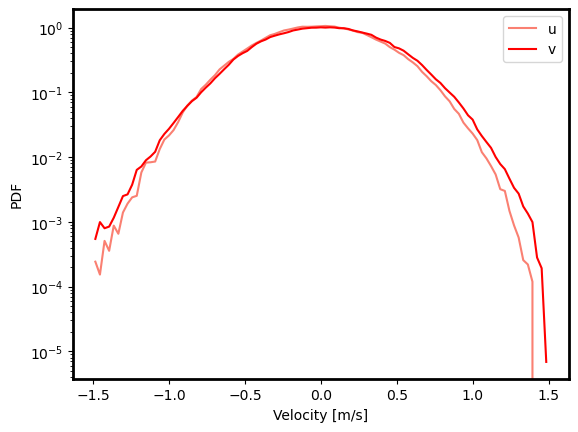

In [5]:
bins = np.linspace(-1.5, 1.5, 100)
histu, b, _ = ds_true.u.plot.hist(bins=bins, density=True);
histv, b, _ = ds_true.v.plot.hist(bins=bins, density=True);
fig, ax = plt.subplots(1, 1)
ax.plot(b[:-1] + np.diff(b)/2, histu, label='u', color = 'salmon')
ax.plot(b[:-1] + np.diff(b)/2, histv, label='v', color = 'red')
ax.legend()
ax.set_xlabel('Velocity [m/s]')
ax.set_ylabel('PDF')
#ax.set_xscale('log')
ax.set_yscale('log')

______________
# Spectra

In [ ]:
fig, axs= plt.subplots(1,3, figsize = (10,4))
axs = axs.flatten()

ax = axs[0]
E.Ex_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
E.Ex_ni.plot(label = 'Near-inertial', color = 'teal', ax=ax)
E.Ex_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
E.Ex_1.plot(label = 'Diurnal',color='blue', ax=ax)
E.Ex.plot(label = 'Total', color = 'k', ax=ax)
(E.freq_time**(-6)).plot(ax=ax, color='orange', label = '-6', ls='--')
(E.freq_time**(-12)).plot(ax=ax, color='red', label = '-12', ls='--')
ax.set_ylabel(r'$PSD_xy$')
ax.set_xlabel('Frequency [cpd]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-14, 1e16)


ax = axs[1]
E.Eu_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
E.Eu_ni.plot(label = 'Near-inertial', color = 'teal', ax=ax)
E.Eu_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
E.Eu_1.plot(label = 'Diurnal',color='blue', ax=ax)
E.Eu.plot(label = 'Total', color = 'k', ax=ax)
(E.freq_time**(-4)*1e-6).plot(ax=ax, color='orange', label = '-4', ls='--')
(E.freq_time**(-10)).plot(ax=ax, color='red', label = '-10', ls='--')
ax.set_ylabel(r'$PSD_{uv}$')
ax.set_xlabel('Frequency [cpd]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-25, 1e6)


ax = axs[2]
E.Ea_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
E.Ea_ni.plot(label = 'Near-inertial', color = 'teal', ax=ax)
E.Ea_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
E.Ea_1.plot(label = 'Diurnal',color='blue', ax=ax)
E.Ea.plot(label = 'Total', color = 'k', ax=ax)
(E.freq_time**(-2)*1e-14).plot(ax=ax, color='orange', label = '-2', ls='--')
(E.freq_time**(-8)*1e8).plot(ax=ax, color='red', label = '-8', ls='--')
ax.set_ylabel(r'$PSD_a$')
ax.set_xlabel('Frequency [cpd]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-25, 1e6)
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(images_dir, 'synth_traj_vel_spectra.png'))

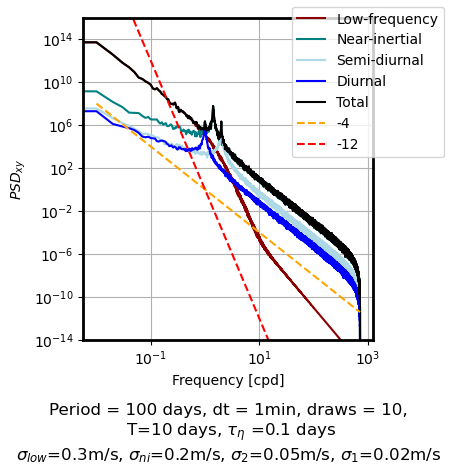

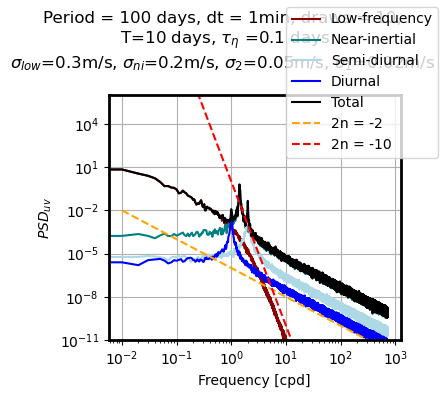

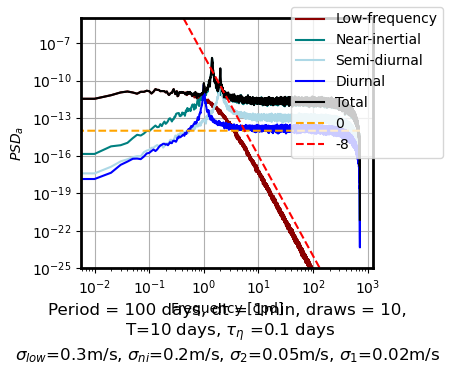

In [11]:
fig0, ax= plt.subplots(1,1, figsize = (4,4))

E.Ex_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
E.Ex_ni.plot(label = 'Near-inertial', color = 'teal', ax=ax)
E.Ex_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
E.Ex_1.plot(label = 'Diurnal',color='blue', ax=ax)
E.Ex.plot(label = 'Total', color = 'k', ax=ax)
(E.freq_time**(-4)).plot(ax=ax, color='orange', label = '-4', ls='--')
(E.freq_time**(-12)).plot(ax=ax, color='red', label = '-12', ls='--')
ax.set_ylabel(r'$PSD_{xy}$')
ax.set_xlabel('Frequency [cpd]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
ax.set_ylim(1e-14, 1e16)
fig0.legend()
fig0.tight_layout()
ax.set_title(param_str, y=-0.4)
fig0.savefig(os.path.join(images_dir, 'synth_traj_xy_spectra.png'), dpi = 200)

fig1, ax= plt.subplots(1,1, figsize = (4,4))
E.Eu_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
E.Eu_ni.plot(label = 'Near-inertial', color = 'teal', ax=ax)
E.Eu_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
E.Eu_1.plot(label = 'Diurnal',color='blue', ax=ax)
E.Eu.plot(label = 'Total', color = 'k', ax=ax)
(E.freq_time**(-2)*1e-6).plot(ax=ax, color='orange', label = '2n = -2', ls='--')
(E.freq_time**(-10)).plot(ax=ax, color='red', label = '2n = -10', ls='--')
ax.set_ylabel(r'$PSD_{uv}$')
ax.set_xlabel('Frequency [cpd]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
ax.set_ylim(1e-11, 1e6)
fig1.legend()
fig1.suptitle(param_str)
fig1.tight_layout()
fig1.savefig(os.path.join(images_dir, 'synth_traj_vel_spectra.png'), dpi = 200)

fig2, ax= plt.subplots(1,1, figsize = (4,4))
E.Ea_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
E.Ea_ni.plot(label = 'Near-inertial', color = 'teal', ax=ax)
E.Ea_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
E.Ea_1.plot(label = 'Diurnal',color='blue', ax=ax)
E.Ea.plot(label = 'Total', color = 'k', ax=ax)
(E.freq_time**(0)*1e-14).plot(ax=ax, color='orange', label = '0', ls='--')
(E.freq_time**(-8)*1e-8).plot(ax=ax, color='red', label = '-8', ls='--')
ax.set_ylabel(r'$PSD_a$')
ax.set_xlabel('Frequency [cpd]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
ax.set_ylim(1e-25, 1e-5)
fig2.legend()
ax.set_title(param_str, y=-0.4)
fig2.tight_layout()
fig2.savefig(os.path.join(images_dir, 'synth_traj_acc_spectra.png'), dpi = 200)

______________
# Time series

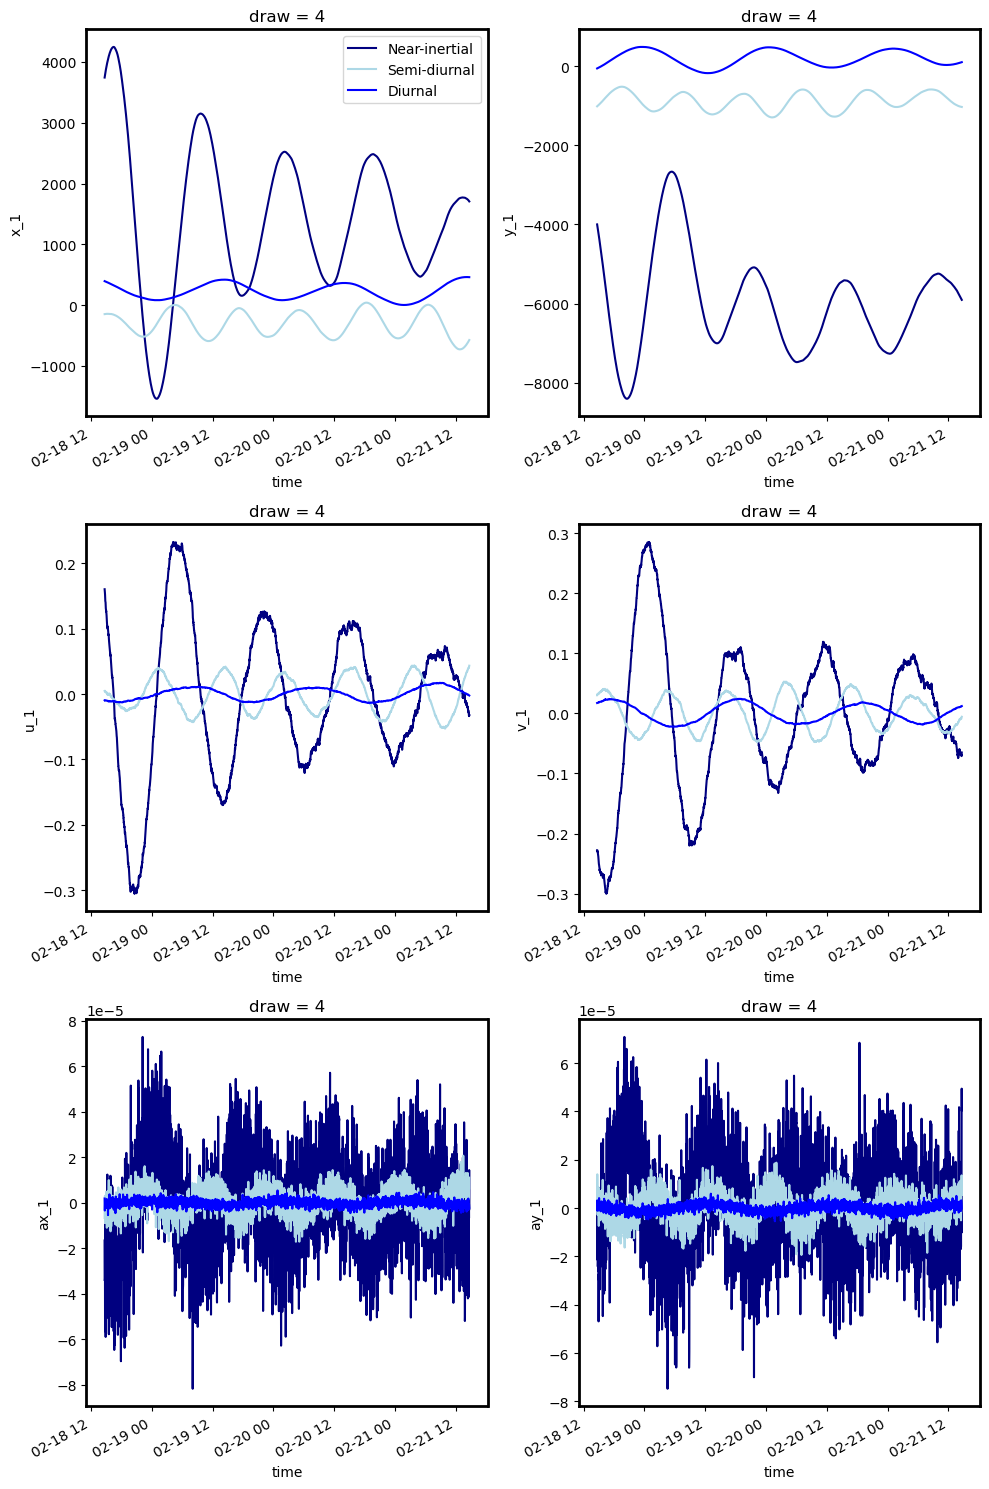

In [153]:
draw=4
nb_jours = 3
start = 70000
ds_ = ds_true.isel(draw=draw).isel(time =slice(start, start + 24*60*nb_jours))

fig, axs= plt.subplots(3,2, figsize = (10,15))
axs = axs.flatten()

ax = axs[0]
#ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.x_ni.plot(label = 'Near-inertial', color = 'navy', ax=ax)
ds_.x_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
ds_.x_1.plot(label = 'Diurnal',color='blue', ax=ax)
ax.legend()

ax = axs[1]
#ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.y_ni.plot(label = 'Near-inertial', color = 'navy', ax=ax)
ds_.y_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
ds_.y_1.plot(label = 'Diurnal',color='blue', ax=ax)

ax = axs[2]
#ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.u_ni.plot(label = 'Near-inertial', color = 'navy', ax=ax)
ds_.u_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
ds_.u_1.plot(label = 'Diurnal',color='blue', ax=ax)

ax = axs[3]
#ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.v_ni.plot(label = 'Near-inertial', color = 'navy', ax=ax)
ds_.v_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
ds_.v_1.plot(label = 'Diurnal',color='blue', ax=ax)

ax = axs[4]
#ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.ax_ni.plot(label = 'Near-inertial', color = 'navy', ax=ax)
ds_.ax_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
ds_.ax_1.plot(label = 'Diurnal',color='blue', ax=ax)

ax = axs[5]
#ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.ay_ni.plot(label = 'Near-inertial', color = 'navy', ax=ax)
ds_.ay_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
ds_.ay_1.plot(label = 'Diurnal',color='blue', ax=ax)

fig.tight_layout()

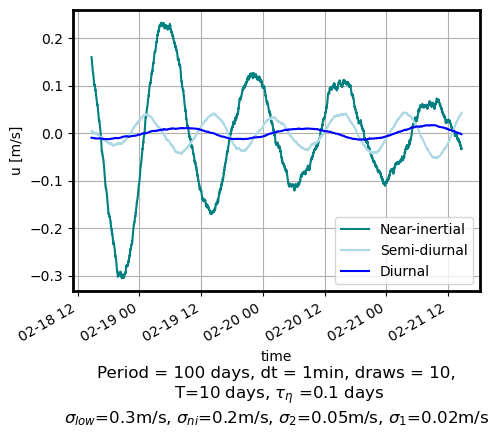

In [165]:
draw=4
nb_jours = 3
start = 70000
ds_ = ds_true.isel(draw=draw).isel(time =slice(start, start + 24*60*nb_jours))

fig, ax= plt.subplots(1,1, figsize = (5,5))

#ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.u_ni.plot(label = 'Near-inertial', color = 'teal', ax=ax)
ds_.u_2.plot(label = 'Semi-diurnal', color = 'lightblue', ax=ax)
ds_.u_1.plot(label = 'Diurnal',color='blue', ax=ax)
ax.set_ylabel('u [m/s]')
ax.grid()
ax.legend()
ax.set_title(param_str, y=-0.5)
fig.tight_layout()

______________
# X/Y plot

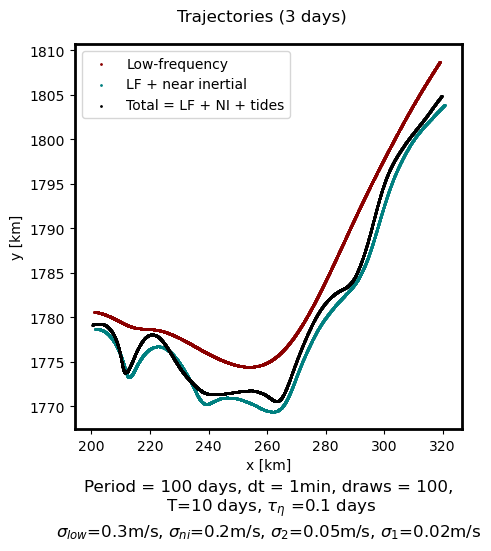

In [117]:
draw=4
nb_jours = 3
start = 70000
_ds = ds_true.isel(draw=draw).isel(time =slice(start, start + 24*60*nb_jours))
fig, ax= plt.subplots(1,1, figsize = (5,5))
ax.scatter(_ds.x_low/1000, _ds.y_low/1000, s=1, color = 'darkred', label = 'Low-frequency')
ax.scatter(_ds.x_low/1000 + _ds.x_ni/1000, _ds.y_low/1000 +_ds.y_ni/1000, s=1, color = 'teal', label = 'LF + near inertial')
ax.scatter(_ds.x/1000, _ds.y/1000, s=1, color = 'k', label = 'Total = LF + NI + tides')
ax.legend()
ax.set_title(param_str, y=-0.3)
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
fig.suptitle(f'Trajectories ({nb_jours} days)', y=0.95 )
fig.savefig(os.path.join(images_dir, 'synth_traj_zoom_traj_comp.png'), dpi = 200)

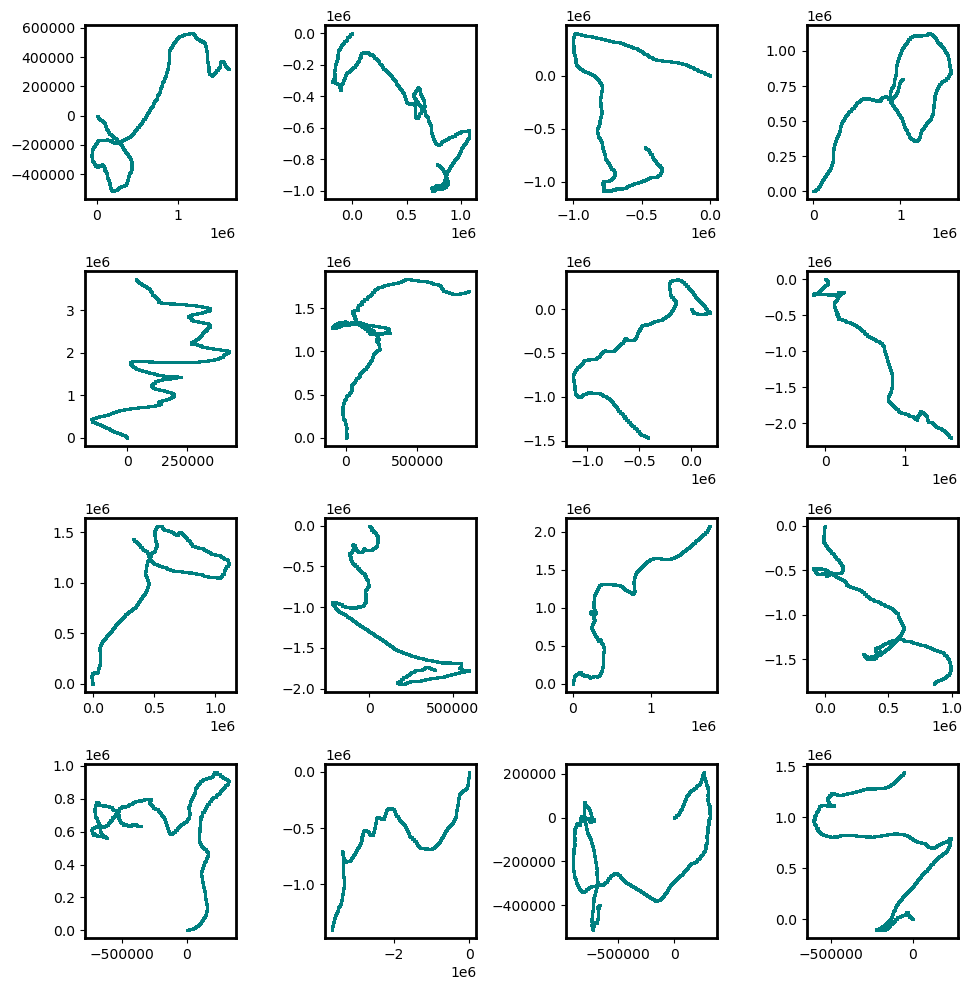

In [101]:
fig, axs = plt.subplots(4,4, figsize = (10,10))
axs = axs.flatten()
for i in range(len(axs)) : 
    ax=axs[i]
    _ds = ds_true.isel(draw=i)
    ax.scatter(_ds.x, _ds.y, s=1, color = 'teal')
fig.tight_layout()